# XGboost regression for solubility prediction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# load dataset we are using
df = pd.read_csv('curated_aqsoldb.csv')

In [3]:
# creating x matrix from descriptors chosen
x = df[['MolLogP', 'MolWt', 'NumRotatableBonds', 'AP']]
x

,MolLogP,MolWt,NumRotatableBonds,AP
0,3.95810,392.510,17.0,0.000000
1,2.40550,169.183,0.0,0.769231
2,2.15250,140.569,1.0,0.666667
3,8.11610,756.226,10.0,0.679245
4,2.48540,422.525,12.0,0.387097
...,...,...,...,...
10058,2.61700,264.369,8.0,0.315789
10059,-0.21440,444.440,2.0,0.187500
10060,2.82402,150.221,1.0,0.545455
10061,5.09308,454.611,13.0,0.363636


In [4]:
# creating y matrix from Solubility values
y = df['Solubility']

In [5]:
# split dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y)

Dmatrix is an optimized data structure that XGboost uses. Here we will input our descriptors as the data parameter and solubility values as the label parameter.

In [6]:
# create D matrix where data is the descriptors being used and label is the solubility values
dmatrix = xgb.DMatrix(data=x,label=y)

In [7]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [8]:
xg_reg.fit(x_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [9]:
y_predict = xg_reg.predict(x_test)

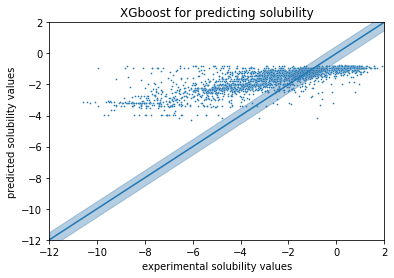

In [10]:
sns.scatterplot(x=y_test, y=y_predict, s=3).set(title='XGboost for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')

plt.xlim(-12, 2)
plt.ylim(-12, 2)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

# shaded areas show values that lie within the accepted +- 0.5 error zone
exp_value = np.arange(-12, 3)
upper_bound = exp_value + 0.5
lower_bound = exp_value - 0.5
plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)

In [11]:
xg_reg = xgb.train(params={"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,'max_depth': 5, 'alpha': 10}, dtrain=dmatrix, num_boost_round=10)

In [12]:
y_predict = xg_reg.predict(x_test)

TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'pandas.core.frame.DataFrame'>)

In [ ]:
sns.scatterplot(x=y_test, y=y_predict, s=3).set(title='XGboost for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')

plt.xlim(-12, 2)
plt.ylim(-12, 2)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

# shaded areas show values that lie within the accepted +- 0.5 error zone
exp_value = np.arange(-12, 3)
upper_bound = exp_value + 0.5
lower_bound = exp_value - 0.5
plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)

In [ ]:
cv_results = xgb.cv(dtrain=dmatrix, params={"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,'max_depth': 5, 'alpha': 10}, nfold=3,num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [ ]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 50]
plt.savefig('tree.jpg', dpi=500)
plt.show()

In [ ]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()